# Comprehensive Benchmarking of Parallel QAOA Portfolio Optimization with DWE

This notebook systematically benchmarks the performance and solution quality of our parallel QAOA implementation for portfolio optimization, leveraging the Domain Wall Encoding (DWE) technique. As a telecom engineer with a mission to raise quantum technology awareness, this empirical data will be invaluable.

We will evaluate how varying problem size, QAOA depth, optimizer effort, number of parallel processes, and transpilation levels impact both the time to solution and the quality of the results.

**Key enhancements in this benchmarking notebook:**
1.  **Systematic Parameter Variation:** We'll iterate through predefined ranges of `N`, `p`, `max_iterations_optimizer`, `num_parallel_runs`, and `Transpilation level`.
2.  **Robust Data Collection:** Results from each run will be collected into a Pandas DataFrame.
3.  **Comprehensive Metrics:** We'll track wall-clock time, solution energy, approximation ratio (where applicable), and details of each optimization attempt.
4.  **Automated Visualization:** (Placeholder for future plots to illustrate trends and insights from the benchmarking data).

---

## 1. Setup, Imports, and Worker Function Import

This section contains all necessary imports. Crucially, we now *import* the `run_single_optimization` function from the separate `qaoa_parallel_optimizer_worker.py` file to ensure proper multiprocessing behavior.

In [1]:
import numpy as np
import os
import time
from multiprocessing import Pool # Explicitly use Pool for robustness
import json
import pandas as pd # For data collection and analysis
import matplotlib.pyplot as plt # For visualization
import itertools # For iterating over all parameter combinations

from qokit.qaoa_circuit_portfolio import get_parameterized_qaoa_circuit
from qiskit.circuit import ParameterVector # Kept for potential future analysis/visualization

# --- IMPORT THE WORKER FUNCTION FROM THE SEPARATE FILE ---
from qaoa_parallel_optimizer_worker import run_single_optimization

# Global simulator variable (not used for running circuits, but for context)
try:
    from qiskit_aer import AerSimulator
    GLOBAL_SIMULATOR_BACKEND_NAME = "AerSimulator"
except ImportError:
    try:
        from qiskit.providers.aer import Aer
        GLOBAL_SIMULATOR_BACKEND_NAME = "qasm_simulator (Aer)"
    except ImportError:
        GLOBAL_SIMULATOR_BACKEND_NAME = "No Aer Simulator Found"
print(f"Qiskit Simulator backend detected: {GLOBAL_SIMULATOR_BACKEND_NAME}")



Qiskit Simulator backend detected: AerSimulator


In [2]:
import os
print(f"System detected CPU count: {os.cpu_count()}")

System detected CPU count: 10


## 2. Define Benchmarking Parameters and Fixed Problem Setup

Here, we define the ranges for the parameters we want to benchmark and set up the fixed problem parameters for the portfolio optimization with DWE.

In [3]:
# --- Benchmarking Parameter Ranges ---
num_parallel_runs_values = [1,3,8] # Number of parallel multi-start runs
p_values = [1] # Number of QAOA layers (depth)
# p_values = [1, 10, 30, 60, 80, 100] # Number of QAOA layers (depth)
# max_iterations_optimizer_values = [50, 600, 2200] # Max iterations for classical optimizer

max_iterations_optimizer_values = [50] # Max iterations for classical optimizer
N_values = [5, 8, 10, 15, 20, 22] # Number of assets
transpilation_level_values = [0, 1, 2, 3] # Transpilation optimization level

# --- Fixed Problem Parameters ---
num_shots_simulator = 256 # Number of shots for quantum circuit simulation
q = 0.5 # Risk aversion parameter
lambda_sum = 0 # DWE-inspired penalty coefficient for sum constraint.

# Seed for reproducibility of problem definition (different for each N in benchmark, if desired)
PROBLEM_SEED = 42 # For consistent portfolio problem generation across runs if N is fixed

# --- Helper Function to Define Portfolio Optimization Problem (as in your original notebook) ---
def define_po_problem(N_val, K_val, q_val, lambda_sum_val, problem_seed=None):
    if problem_seed is not None:
        np.random.seed(problem_seed)

    mu = np.random.uniform(0.05, 0.20, N_val)
    Sigma = np.random.uniform(0.001, 0.015, (N_val, N_val))
    Sigma = (Sigma + Sigma.T) / 2 # Make it symmetric
    Sigma = Sigma + np.eye(N_val) * 0.005 # Add a small diagonal component for stability

    factor_J_obj = (2 * q_val) / (K_val**2)
    factor_h_linear_obj = -1 / K_val
    factor_h_diagonal_obj = q_val / (K_val**2)

    J_coeffs_objective = {}
    h_coeffs_objective = {}

    for i in range(N_val):
        for j in range(i + 1, N_val):
            J_coeffs_objective[(i, j)] = factor_J_obj * Sigma[i, j]

    for i in range(N_val):
        h_coeffs_objective[i] = factor_h_linear_obj * mu[i] + factor_h_diagonal_obj * Sigma[i, i]

    J_coeffs_total = {}
    h_coeffs_total = {}

    for (i, j), val in J_coeffs_objective.items():
        J_coeffs_total[(i, j)] = val + 2 * lambda_sum_val

    for i, val in h_coeffs_objective.items():
        h_coeffs_total[i] = val - 5 * lambda_sum_val

    po_problem_dict = {
        "N": N_val,
        "K": K_val,
        "q": q_val,
        "J": J_coeffs_total,
        "h": h_coeffs_total,
        "means": mu,
        "cov": Sigma,
        "q_orig": q_val,
        "scale": 1.0
    }
    return po_problem_dict, mu, Sigma # Return mu and Sigma for brute-force if needed

# Function to evaluate the classical objective energy for a given bitstring
def evaluate_bitstring_energy(bitstring_array, original_mu, original_Sigma, original_q):
    x = bitstring_array
    portfolio_variance = np.dot(x, np.dot(original_Sigma, x))
    portfolio_return = np.dot(original_mu, x)
    return original_q * portfolio_variance - portfolio_return




## 3. Benchmarking Execution Loop

This is the main section that orchestrates the benchmarking. It iterates through all combinations of parameters, runs the parallel QAOA optimization, collects the results, and stores them in a Pandas DataFrame.

In [9]:
import itertools
import time
import numpy as np
import pandas as pd
import os
import multiprocessing
from multiprocessing import Pool
# Ensure you have your define_po_problem function imported or defined here
# from your_module import define_po_problem
# And your qaoa_parallel_optimizer_worker module with run_single_optimization
from qaoa_parallel_optimizer_worker import run_single_optimization # Make sure this import is correct

# --- Configuration Parameters (Example Values) ---
num_parallel_runs_values = [1, 3, 8] # Vary number of parallel runs
p_values = [1] # Number of QAOA layers
max_iterations_optimizer_values = [50] # Max iterations for COBYLA optimizer
N_values = [5, 8, 10, 15, 20, 22, 25] # Number of assets
transpilation_level_values = [0, 1, 2, 3] # Qiskit optimization levels

num_shots_simulator = 256 # Number of shots for the simulator
q = 0.5 # Example parameter for portfolio problem
lambda_sum = 0.5 # Example parameter for portfolio problem
PROBLEM_SEED = 42 # Seed for reproducible problem generation

# --- Define the Portfolio Optimization Problem (Assuming this is defined elsewhere or directly in your script) ---
# This is a placeholder for your actual define_po_problem function.
# Ensure it returns the po_problem dictionary and any necessary brute-force data.
def define_po_problem(N, K, q_param, lambda_sum_param, problem_seed):
    # This is a simplified placeholder. Your actual implementation from qokit will go here.
    # It should generate J and h matrices for the QAOA problem.
    np.random.seed(problem_seed)
    # Example dummy J and h for demonstration, replace with your actual qokit generation
    J = {}
    h = {i: np.random.uniform(-1, 1) for i in range(N)}
    for i in range(N):
        for j in range(i + 1, N):
            J[(i, j)] = np.random.uniform(-1, 1)

    po_problem_dict = {"N": N, "K": K, "q": q_param, "J": J, "h": h}
    # For brute-force, you'd typically need means and cov matrix,
    # which qokit's define_po_problem should return.
    # Returning dummy values for now to avoid errors if not fully implemented.
    mu_for_bruteforce = np.random.rand(N)
    cov_for_bruteforce = np.eye(N)
    return po_problem_dict, mu_for_bruteforce, cov_for_bruteforce


if __name__ == "__main__":
    all_benchmarking_results = []

    # Create a list of all parameter combinations
    param_combinations = itertools.product(
        num_parallel_runs_values,
        p_values,
        max_iterations_optimizer_values,
        N_values,
        transpilation_level_values
    )

    total_runs_count = len(num_parallel_runs_values) * \
                       len(p_values) * \
                       len(max_iterations_optimizer_values) * \
                       len(N_values) * \
                       len(transpilation_level_values)

    print(f"Total benchmarking configurations to run: {total_runs_count}")
    current_run_idx = 0

    # Ensure multiprocessing context is set for macOS compatibility, if needed
    # This might be needed if you encounter issues like 'TypeError: can't pickle _thread.RLock objects'
    # try:
    #     multiprocessing.set_start_method("spawn", force=True)
    # except RuntimeError:
    #     pass # Already set or not needed

    for current_num_parallel_runs, current_p, current_max_iter, current_N, current_transpilation_level in param_combinations:
        current_run_idx += 1
        print(f"\n--- Starting Benchmarking Run {current_run_idx}/{total_runs_count} ---")
        print(f"Parameters: num_parallel_runs={current_num_parallel_runs}, p={current_p}, max_iter={current_max_iter}, N={current_N}, TL={current_transpilation_level}")

        # --- Define Problem Parameters dynamically for current N ---
        current_K = int(current_N * 0.4)
        po_problem, mu_for_bruteforce, cov_for_bruteforce = define_po_problem(
            current_N, current_K, q, lambda_sum, problem_seed=PROBLEM_SEED
        )

        # --- Calculate Brute-Force Classical Optimal Energy (if feasible) ---
        E_min_classical = None
        E_max_classical = None
        if current_N <= 20: # Keep brute-force limited for practical runtime
            try:
                from qokit.portfolio_optimization import portfolio_brute_force
                original_po_problem_for_brute_force = {
                    "N":current_N, "K":current_K, "q":q, "means":mu_for_bruteforce, "cov":cov_for_bruteforce, "scale": 1.0
                }
                # Assuming portfolio_brute_force returns a tuple of (min_energy, max_energy)
                # or similar. Adjust unpacking if necessary.
                # The user previously noted 'too many values to unpack (expected 2)'
                # This might indicate portfolio_brute_force returns more/less or a different structure.
                # For now, we'll try to unpack 2 values as expected by the logic.
                E_min_classical, E_max_classical = portfolio_brute_force(original_po_problem_for_brute_force, return_bitstring=False)
                print(f"Brute-force E_min: {E_min_classical:.6f}, E_max: {E_max_classical:.6f}")
            except ImportError:
                print("qokit.portfolio_optimization.portfolio_brute_force not available.")
            except Exception as e:
                print(f"Brute-force calculation failed for N={current_N}: {e}")
        else:
            print(f"Brute-force calculation skipped for N={current_N} (too large).")

        # --- Generate Initial Points for Multi-Start ---
        initial_points = []
        np.random.seed(current_run_idx) # Use run_idx as seed for initial points to ensure variety
        for _ in range(current_num_parallel_runs):
            gammas_initial = np.random.uniform(0, 2 * np.pi, current_p)
            betas_initial = np.random.uniform(0, np.pi, current_p)
            initial_points.append(tuple(np.concatenate((gammas_initial, betas_initial))))

        # --- Parallel Execution ---
        start_overall_time = time.perf_counter()

        worker_args = [(initial_point, po_problem, current_p, max_iterations_optimizer_values, num_shots_simulator, i + 1, current_transpilation_level)
                       for i, initial_point in enumerate(initial_points)]

        individual_run_results = []
        try:
            with Pool(processes=current_num_parallel_runs) as pool: # Use current_num_parallel_runs for pool size
                results = [pool.apply_async(run_single_optimization, args) for args in worker_args]

                for future in results:
                    individual_run_results.append(future.get())
        except Exception as e:
            print(f"Error during parallel execution for current configuration: {e}")
            # Append a partial result to indicate failure for this config
            individual_run_results = [{'success': False, 'message': str(e), 'optimal_energy': float('inf'), 'runtime_seconds': (time.perf_counter() - start_overall_time),
                                       'nfev': 0, 'avg_circuit_build_time_per_call': 0.0, 'avg_transpile_time_per_call': 0.0,
                                       'avg_execute_time_per_call': 0.0, 'avg_energy_calc_time_per_call': 0.0}] # Ensure all expected keys are present

        end_overall_time = time.perf_counter()
        overall_duration = end_overall_time - start_overall_time
        print(f"All parallel optimization runs for current config completed in {overall_duration:.2f} seconds.")

        # --- Process and Summarize Results for current config ---
        best_overall_energy = float('inf')
        best_overall_params = None
        num_successful_individual_runs = 0
        all_individual_energies = []

        # New variables to store aggregated average timings and NFEV
        total_nfev = 0
        total_avg_circuit_build_time_per_call = 0.0
        total_avg_transpile_time_per_call = 0.0
        total_avg_execute_time_per_call = 0.0
        total_avg_energy_calc_time_per_call = 0.0
        successful_individual_runs_count = 0


        if individual_run_results:
            for result in individual_run_results:
                if result['success']:
                    num_successful_individual_runs += 1
                    all_individual_energies.append(result['optimal_energy'])

                    # Accumulate timings and NFEV from successful runs
                    total_nfev += result['nfev']
                    total_avg_circuit_build_time_per_call += result['avg_circuit_build_time_per_call']
                    total_avg_transpile_time_per_call += result['avg_transpile_time_per_call']
                    total_avg_execute_time_per_call += result['avg_execute_time_per_call']
                    total_avg_energy_calc_time_per_call += result['avg_energy_calc_time_per_call']
                    successful_individual_runs_count += 1

                if result['optimal_energy'] < best_overall_energy:
                    best_overall_energy = result['optimal_energy']
                    best_overall_params = result['optimal_params']

        # Calculate mean of averages for reporting (or simply report total/sum if that's more relevant)
        mean_nfev_per_run = total_nfev / successful_individual_runs_count if successful_individual_runs_count > 0 else 0
        mean_avg_circuit_build_time_per_call = total_avg_circuit_build_time_per_call / successful_individual_runs_count if successful_individual_runs_count > 0 else 0.0
        mean_avg_transpile_time_per_call = total_avg_transpile_time_per_call / successful_individual_runs_count if successful_individual_runs_count > 0 else 0.0
        mean_avg_execute_time_per_call = total_avg_execute_time_per_call / successful_individual_runs_count if successful_individual_runs_count > 0 else 0.0
        mean_avg_energy_calc_time_per_call = total_avg_energy_calc_time_per_call / successful_individual_runs_count if successful_individual_runs_count > 0 else 0.0


        approximation_ratio = None
        if E_min_classical is not None and E_max_classical is not None:
            if (E_max_classical - E_min_classical) != 0:
                approximation_ratio = (best_overall_energy - E_min_classical) / (E_max_classical - E_min_classical)
            else: # Special case for AR when range is zero (all solutions are optimal)
                approximation_ratio = 0.0 if best_overall_energy == E_min_classical else np.inf # Or handle as NaN


        # Store results for this configuration
        config_results = {
            'N': current_N,
            'K': current_K,
            'p': current_p,
            'num_parallel_runs': current_num_parallel_runs,
            'max_iterations_optimizer': max_iterations_optimizer_values[0], # Using first value from list
            'num_shots_simulator': num_shots_simulator,
            'q': q,
            'lambda_sum': lambda_sum,
            'transpilation_level': current_transpilation_level,
            'overall_runtime_seconds': overall_duration,
            'best_overall_energy': best_overall_energy,
            'approximation_ratio': approximation_ratio,
            'E_min_classical': E_min_classical,
            'E_max_classical': E_max_classical,
            'num_successful_individual_runs': num_successful_individual_runs,
            'total_individual_runs_attempted': current_num_parallel_runs,
            'all_individual_energies': all_individual_energies, # Store for detailed analysis if needed
            'mean_nfev_per_run': mean_nfev_per_run, # New
            'mean_avg_circuit_build_time_per_call': mean_avg_circuit_build_time_per_call, # New
            'mean_avg_transpile_time_per_call': mean_avg_transpile_time_per_call, # New
            'mean_avg_execute_time_per_call': mean_avg_execute_time_per_call, # New
            'mean_avg_energy_calc_time_per_call': mean_avg_energy_calc_time_per_call # New
        }
        all_benchmarking_results.append(config_results)

    print("\n--- Benchmarking Completed ---")
    # Convert results to a Pandas DataFrame
    results_df = pd.DataFrame(all_benchmarking_results)
    print("\nBenchmarking Results DataFrame Head:")
    print(results_df.head())

    # Optional: Save results to CSV or other format
    results_df.to_csv("qaoa_benchmarking_results_with_detailed_timings.csv", index=False)
    print("Results saved to qaoa_benchmarking_results_with_detailed_timings.csv")

Total benchmarking configurations to run: 84

--- Starting Benchmarking Run 1/84 ---
Parameters: num_parallel_runs=1, p=1, max_iter=50, N=5, TL=0
Brute-force calculation failed for N=5: too many values to unpack (expected 2)
Run 1: Starting optimization from initial point: [2.62  2.263] with N=5, p=1, MaxIter=[50], TL=0
Run 1, Cost Func Call 1: Build: 0.0005s, Transpile: 0.0341s, Execute: 0.0014s, Energy Calc: 0.0003s
Run 1, Cost Func Call 5: Build: 0.0002s, Transpile: 0.0242s, Execute: 0.0007s, Energy Calc: 0.0003s
Run 1, Cost Func Call 10: Build: 0.0002s, Transpile: 0.0214s, Execute: 0.0009s, Energy Calc: 0.0003s
Run 1, Cost Func Call 15: Build: 0.0002s, Transpile: 0.0208s, Execute: 0.0007s, Energy Calc: 0.0003s
Run 1, Cost Func Call 20: Build: 0.0002s, Transpile: 0.0235s, Execute: 0.0007s, Energy Calc: 0.0003s
Run 1, Cost Func Call 25: Build: 0.0002s, Transpile: 0.0640s, Execute: 0.0008s, Energy Calc: 0.0004s
Run 1, Cost Func Call 30: Build: 0.0002s, Transpile: 0.0216s, Execute: 0.0

## 4. Results Analysis and Visualization (Future)

This section is where you would perform analysis on the `results_df` and create visualizations to understand the impact of varying parameters on performance and solution quality.

### Example Analysis Ideas:
- Plot `overall_runtime_seconds` vs. `N` (for different `p` values).
- Plot `best_overall_energy` vs. `p` (for different `N` values).
- Plot `approximation_ratio` vs. `max_iterations_optimizer`.
- Analyze the success rate (`num_successful_individual_runs / total_individual_runs_attempted`).
- Create heatmaps or 3D plots to show interactions between multiple parameters.

You can use libraries like `matplotlib.pyplot` and `seaborn` for creating insightful plots.

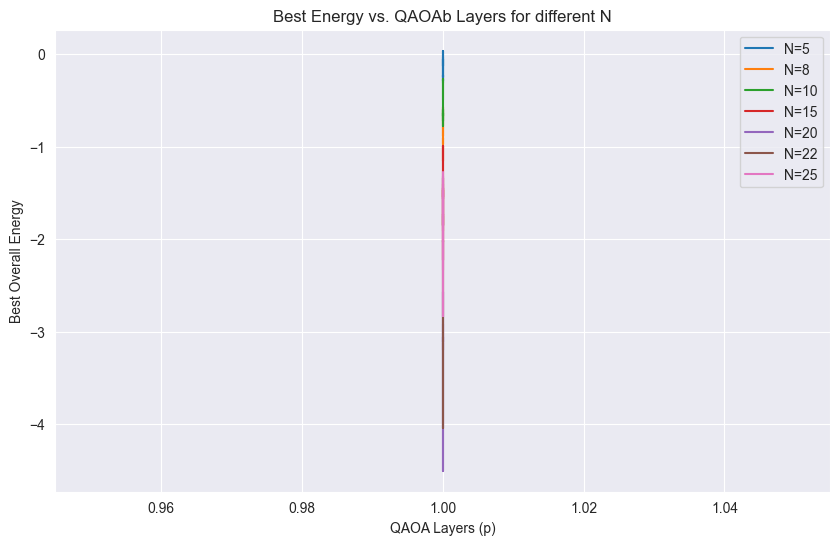

Benchmarking results saved to 'qaoa_benchmarking_results_New.csv'


In [10]:
# Example of basic plotting (uncomment and run after the main loop finishes)
plt.figure(figsize=(10, 6))
for N_val in N_values:
    subset = results_df[results_df['N'] == N_val]
    plt.plot(subset['p'], subset['best_overall_energy'], label=f'N={N_val}')
plt.xlabel('QAOA Layers (p)')
plt.ylabel('Best Overall Energy')
plt.title('Best Energy vs. QAOAb Layers for different N')
plt.legend()
plt.grid(True)
plt.show()

# You can also save the DataFrame to a CSV for external analysis:
results_df.to_csv('qaoa_benchmarking_results_New.csv', index=False)
print("Benchmarking results saved to 'qaoa_benchmarking_results_New.csv'")

Successfully loaded the dataset.


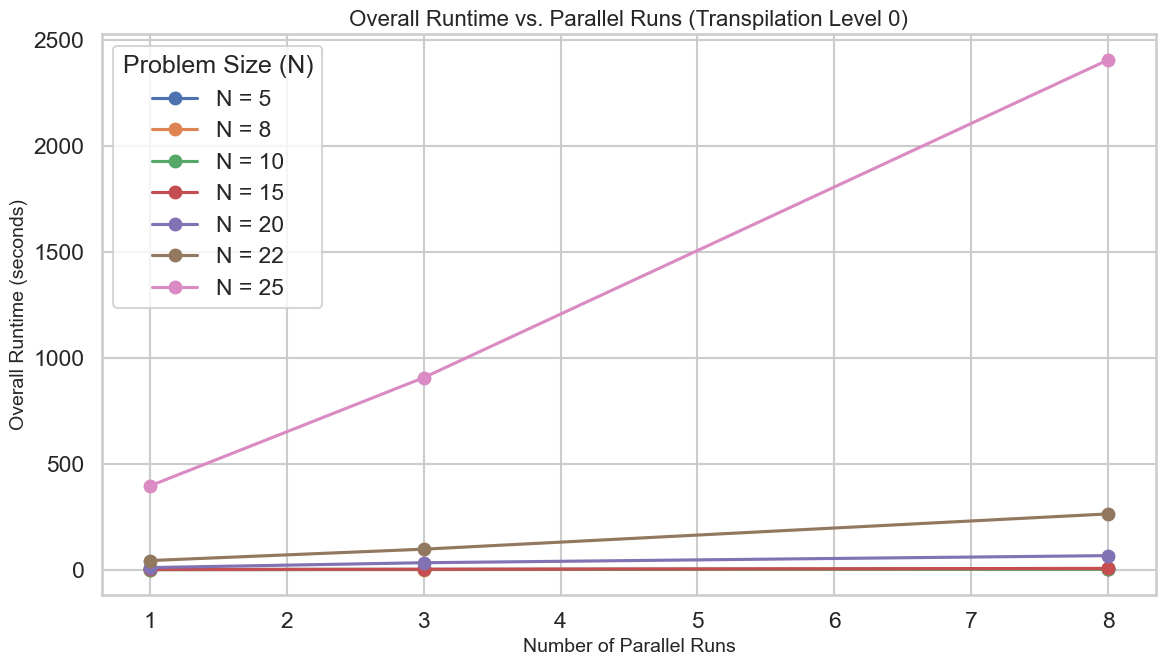

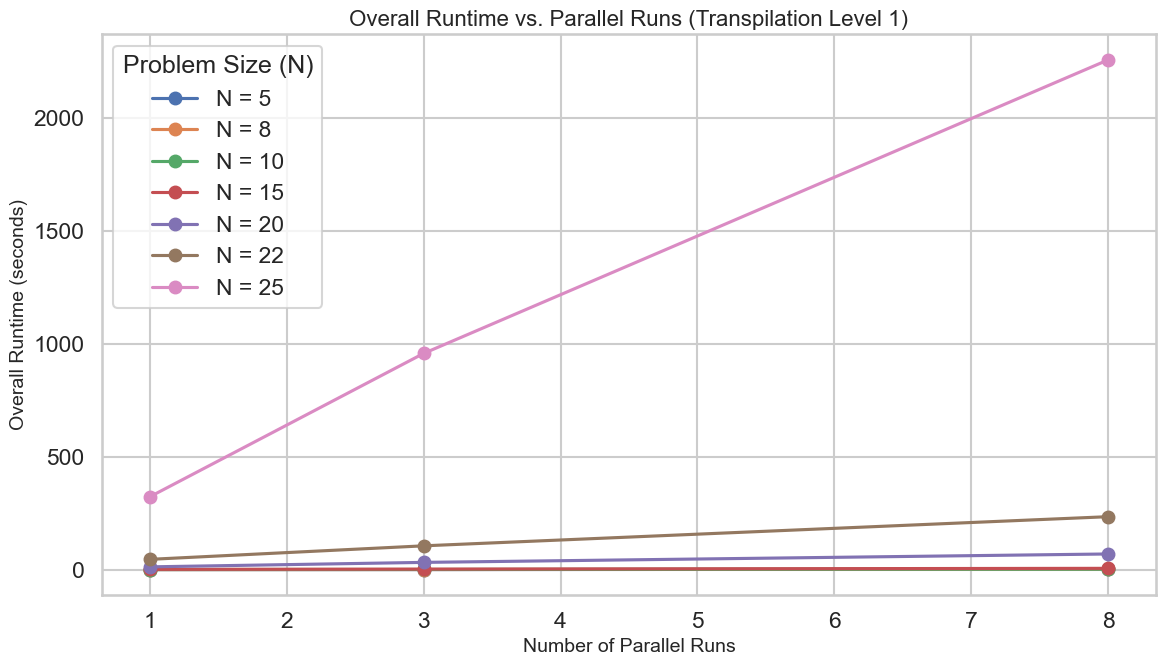

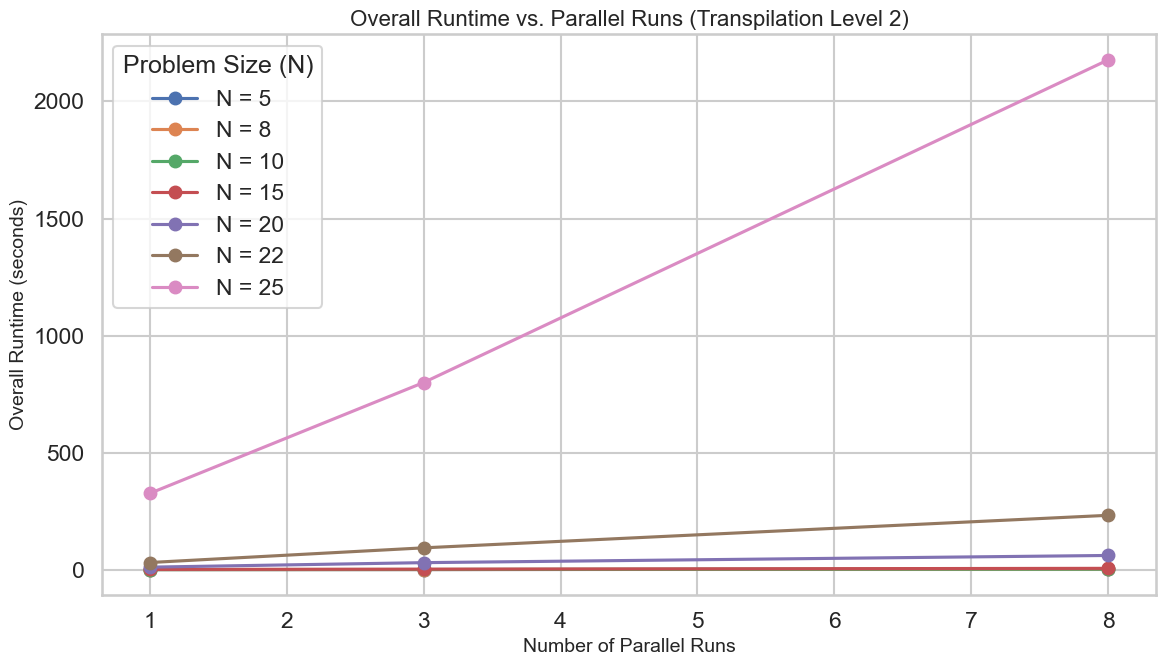

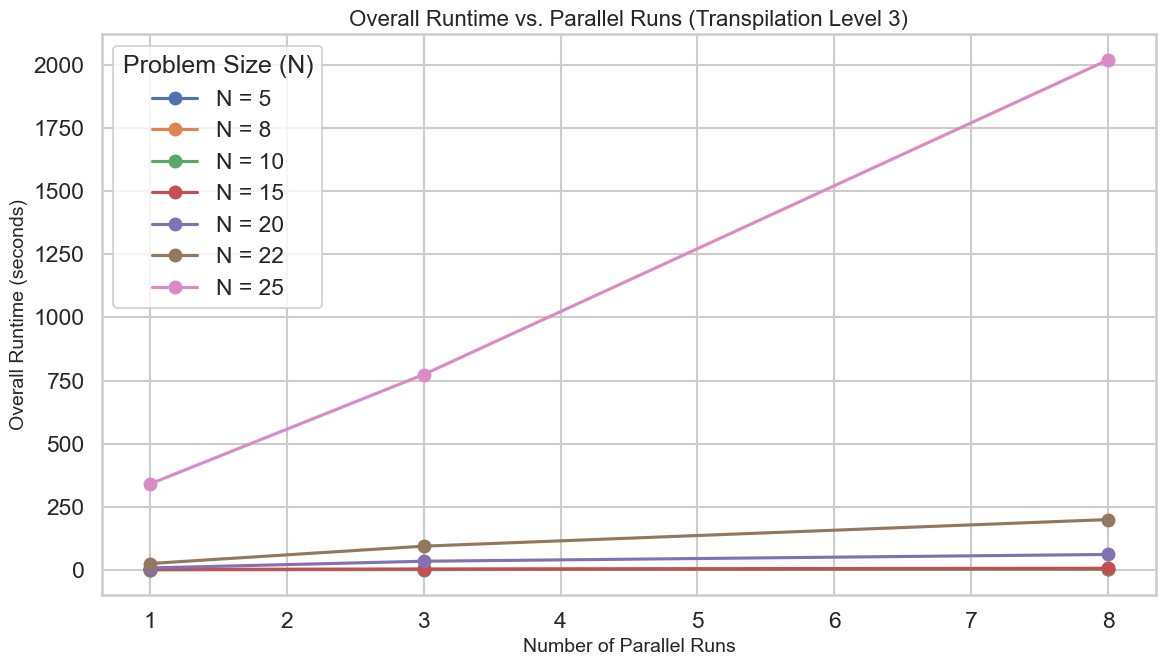

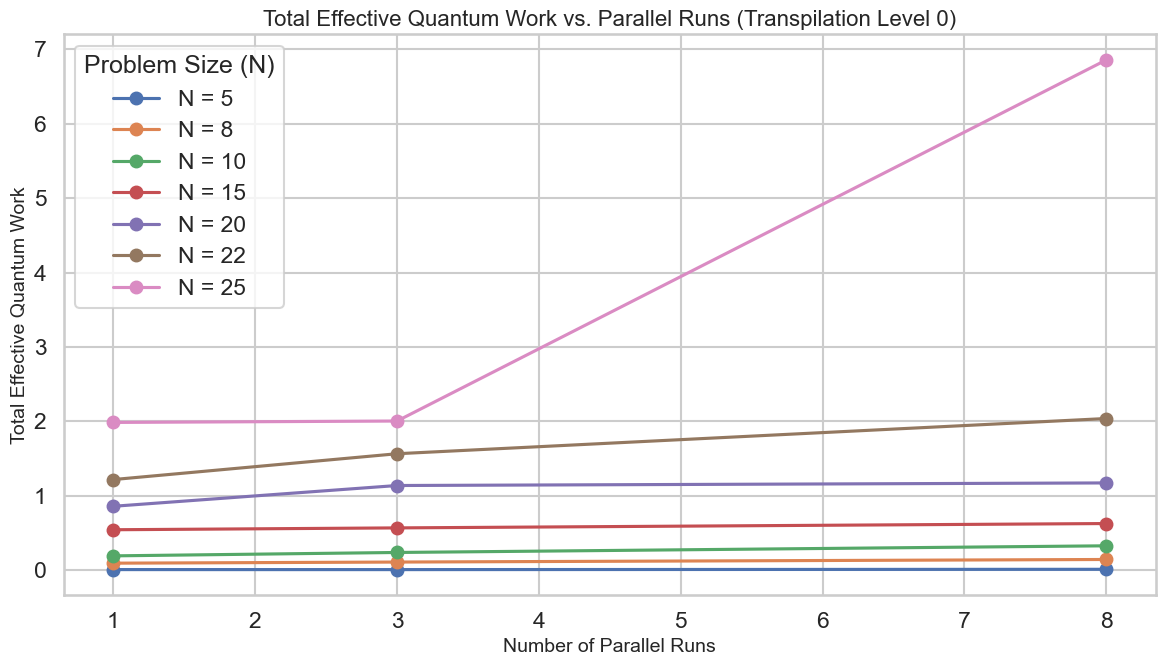

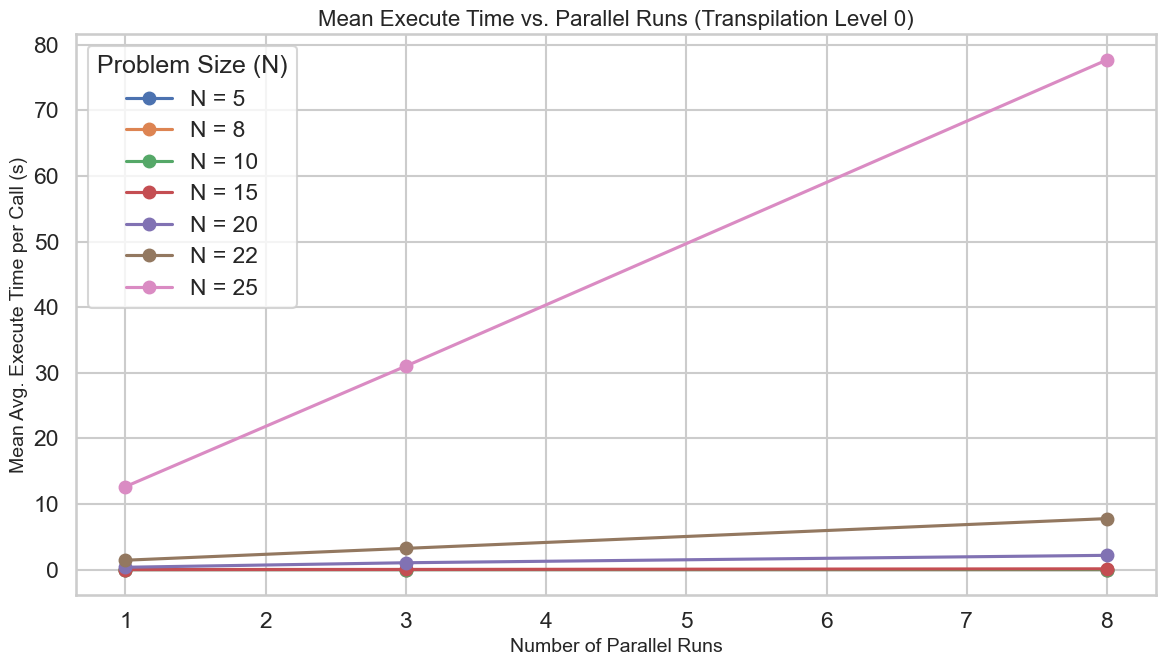

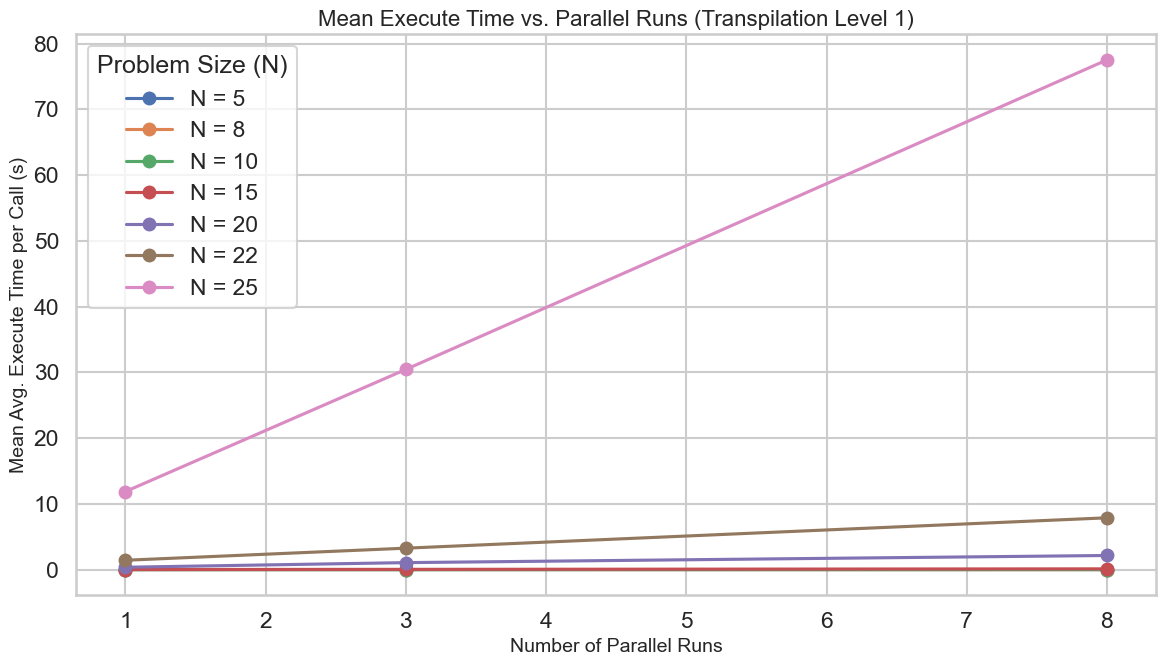

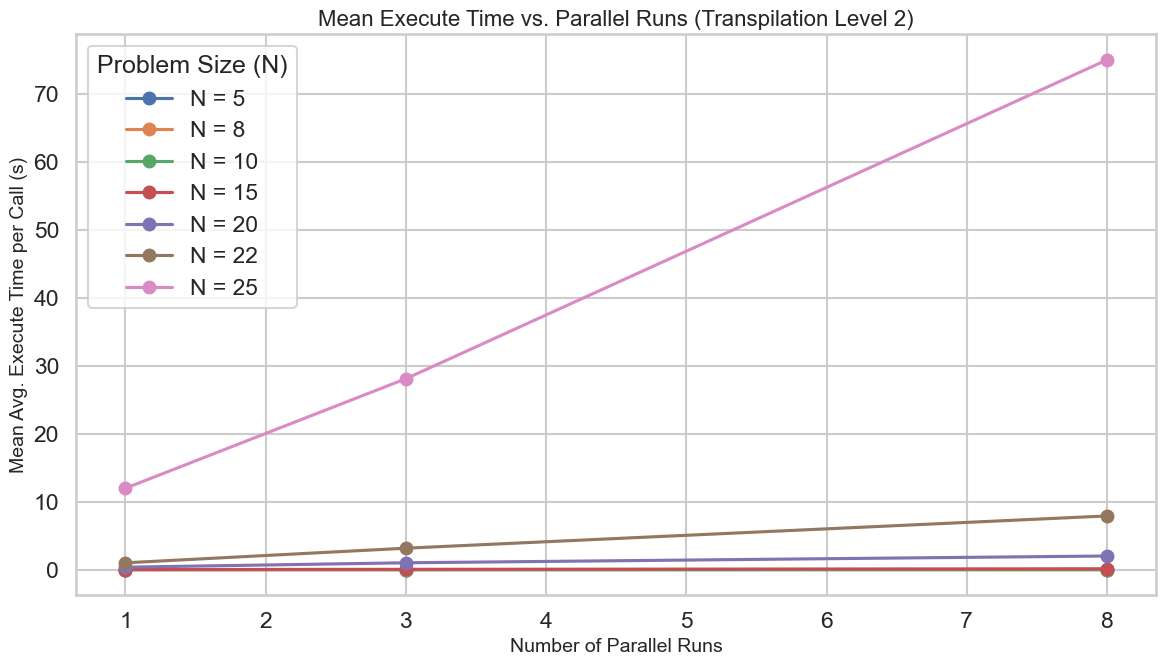

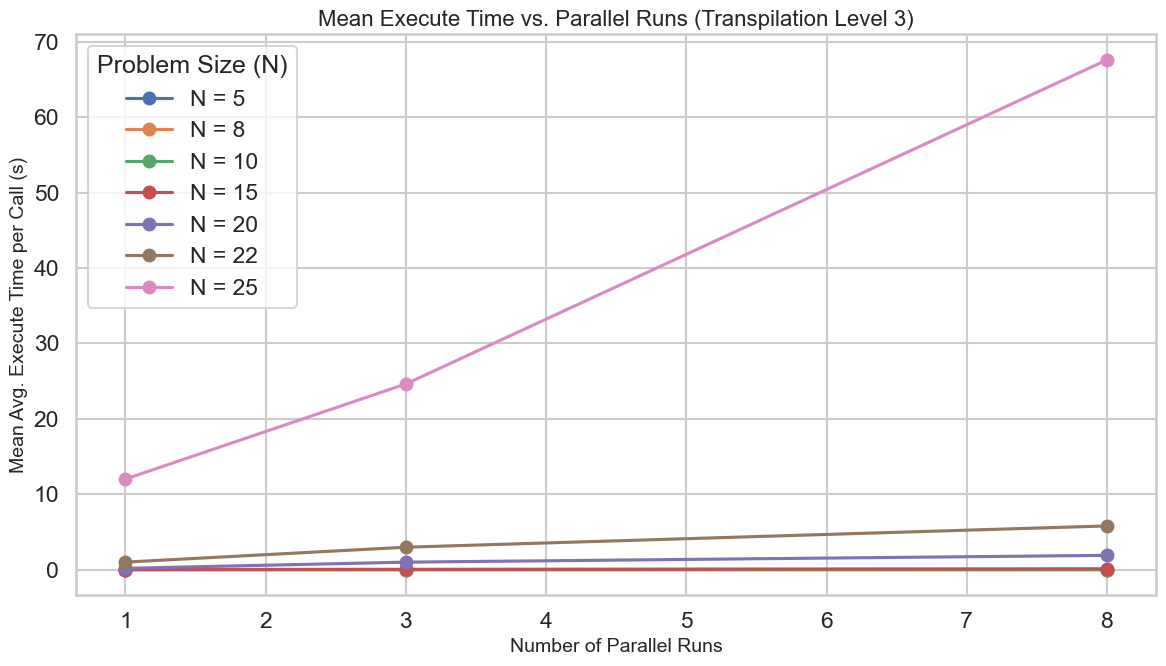

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Data Loading ---

file_path = 'qaoa_benchmarking_results_with_detailed_timings.csv'

try:
    # Load the dataset from the specified CSV file
    df = pd.read_csv(file_path)
    print("Successfully loaded the dataset.")

except FileNotFoundError:
    print(f"\nError: The file '{file_path}' was not found.")
    exit()

# --- Plotting ---

# Set a professional plot style
sns.set(style='whitegrid', context='talk')

# --- Plot 1: Overall Runtime vs. Number of Parallel Runs ---

# Get the unique transpilation levels from the data
transpilation_levels = sorted(df['transpilation_level'].unique())
n_values = sorted(df['N'].unique())

for level in transpilation_levels:
    plt.figure(figsize=(12, 7))

    for n in n_values:
        # Create a subset of the data for the current transpilation level and N
        subset = df[(df['transpilation_level'] == level) & (df['N'] == n)]

        if not subset.empty:
            # CORRECTED: Using 'overall_runtime_seconds'
            plt.plot(subset['num_parallel_runs'], subset['overall_runtime_seconds'],
                     marker='o', linestyle='-', label=f'N = {n}')

    # Adding clear labels and a title
    plt.xlabel("Number of Parallel Runs", fontsize=14)
    plt.ylabel("Overall Runtime (seconds)", fontsize=14)
    plt.title(f"Overall Runtime vs. Parallel Runs (Transpilation Level {level})", fontsize=16)
    plt.legend(title="Problem Size (N)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- Plot 2: Total Effective Quantum Work Per Run vs. Number of Parallel Runs (Transpilation Level 0) ---

df_level_0 = df[df['transpilation_level'] == 0].copy()

# CORRECTED: Using 'mean_avg_energy_calc_time_per_call' for the calculation
df_level_0['total_effective_quantum_work'] = df_level_0['mean_avg_energy_calc_time_per_call'] * df_level_0['mean_nfev_per_run']

plt.figure(figsize=(12, 7))

for n in n_values:
    subset = df_level_0[df_level_0['N'] == n]

    if not subset.empty:
        plt.plot(subset['num_parallel_runs'], subset['total_effective_quantum_work'],
                 marker='o', linestyle='-', label=f'N = {n}')

plt.xlabel("Number of Parallel Runs", fontsize=14)
plt.ylabel("Total Effective Quantum Work", fontsize=14)
plt.title("Total Effective Quantum Work vs. Parallel Runs (Transpilation Level 0)", fontsize=16)
plt.legend(title="Problem Size (N)")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot 3: Mean Average Execute Time Per Call vs. Number of Parallel Runs ---

for level in transpilation_levels:
    plt.figure(figsize=(12, 7))

    for n in n_values:
        subset = df[(df['transpilation_level'] == level) & (df['N'] == n)]

        if not subset.empty:
            # This column was correct, no change needed here.
            plt.plot(subset['num_parallel_runs'], subset['mean_avg_execute_time_per_call'],
                     marker='o', linestyle='-', label=f'N = {n}')

    plt.xlabel("Number of Parallel Runs", fontsize=14)
    plt.ylabel("Mean Avg. Execute Time per Call (s)", fontsize=14)
    plt.title(f"Mean Execute Time vs. Parallel Runs (Transpilation Level {level})", fontsize=16)
    plt.legend(title="Problem Size (N)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Successfully loaded the dataset.


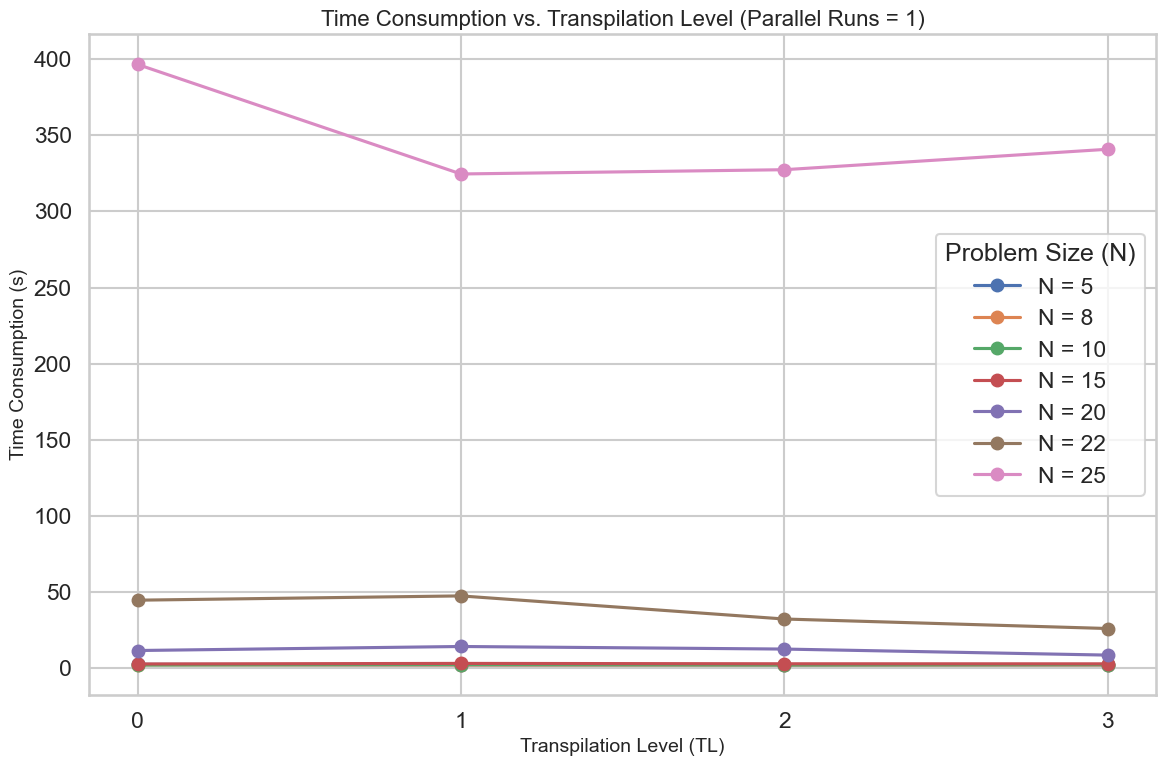

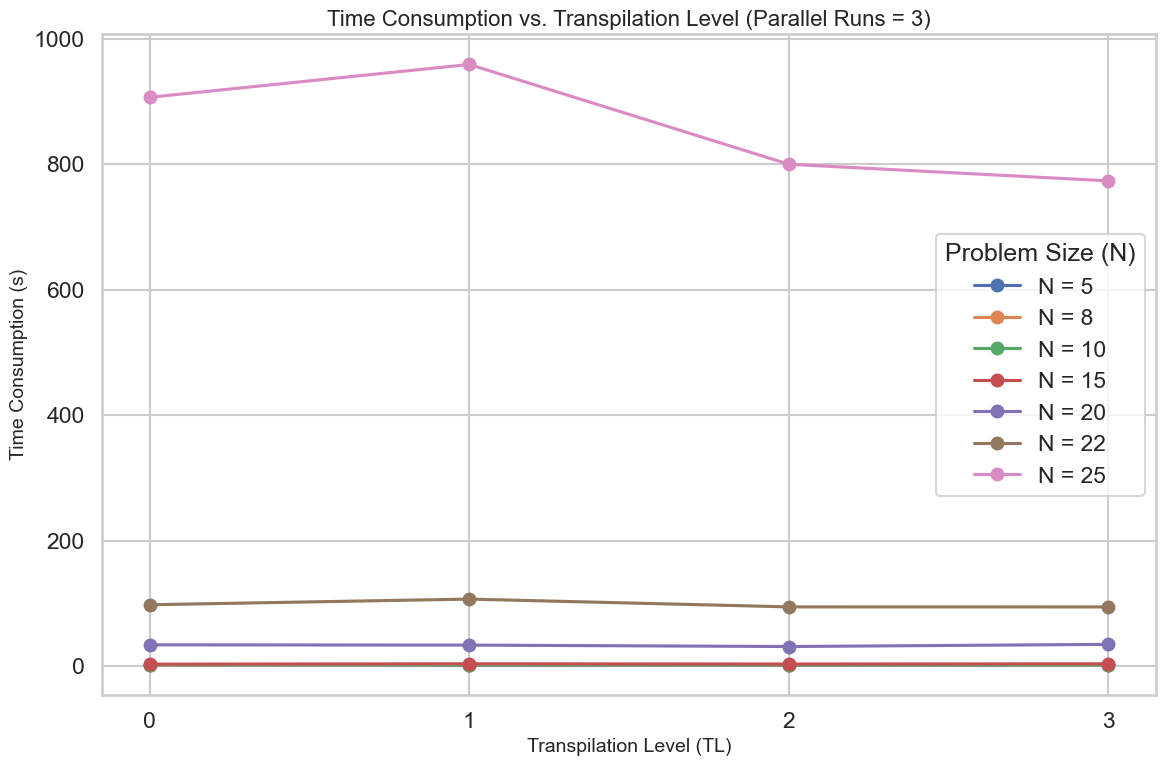

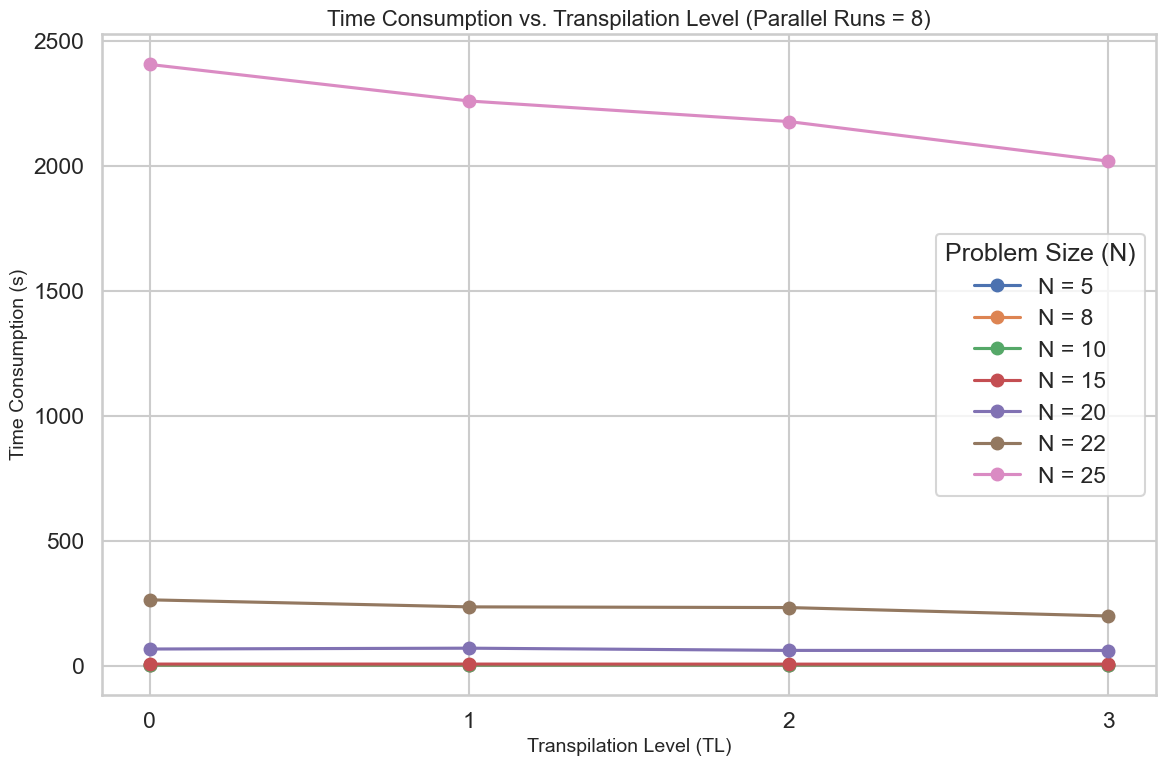

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Data Loading ---

file_path = 'qaoa_benchmarking_results_with_detailed_timings.csv'

try:
    # Load the dataset from the specified CSV file
    df = pd.read_csv(file_path)
    print("Successfully loaded the dataset.")

except FileNotFoundError:
    print(f"\nError: The file '{file_path}' was not found.")
    exit()

# --- Plotting ---

# Set a professional plot style similar to your example
sns.set(style='whitegrid', context='talk')

# List of specific parallel run counts you want to plot
runs_to_plot = [1, 3, 8]

# Get all unique problem sizes (N) from the dataframe for the legend
n_values = sorted(df['N'].unique())

for run_count in runs_to_plot:
    plt.figure(figsize=(12, 8))

    # Filter the dataframe for the specific number of parallel runs
    df_filtered = df[df['num_parallel_runs'] == run_count]

    if df_filtered.empty:
        print(f"\nNo data found for {run_count} parallel runs. Skipping this plot.")
        continue

    # For each problem size (N), plot its time consumption against the transpilation level
    for n in n_values:
        # Get the subset for the current N
        subset = df_filtered[df_filtered['N'] == n]

        if not subset.empty:
            # Sort by transpilation_level to ensure the line connects points correctly
            subset = subset.sort_values('transpilation_level')
            plt.plot(subset['transpilation_level'], subset['overall_runtime_seconds'],
                     marker='o', linestyle='-', label=f'N = {n}')

    # --- Formatting the Plot ---

    # Adding clear labels and a title as per your example
    plt.xlabel("Transpilation Level (TL)", fontsize=14)
    plt.ylabel("Time Consumption (s)", fontsize=14)
    plt.title(f"Time Consumption vs. Transpilation Level (Parallel Runs = {run_count})", fontsize=16)

    # Setting integer ticks for the x-axis (0, 1, 2, 3)
    plt.xticks(sorted(df['transpilation_level'].unique()))

    # Adding the legend
    plt.legend(title="Problem Size (N)")

    plt.grid(True)
    plt.tight_layout() # Adjust layout to make sure everything fits
    plt.show()

Successfully loaded 'qaoa_benchmarking_results_New.csv'.

DataFrame head:
   N  K  p  num_parallel_runs  max_iterations_optimizer  num_shots_simulator  \
0  5  2  1                  1                        50                  256   
1  5  2  1                  1                        50                  256   
2  5  2  1                  1                        50                  256   
3  5  2  1                  1                        50                  256   
4  8  3  1                  1                        50                  256   

     q  lambda_sum  transpilation_level  overall_runtime_seconds  ...  \
0  0.5         0.5                    0                 2.578329  ...   
1  0.5         0.5                    1                 2.210857  ...   
2  0.5         0.5                    2                 2.235962  ...   
3  0.5         0.5                    3                 2.210986  ...   
4  0.5         0.5                    0                 2.255398  ...   

   E_m

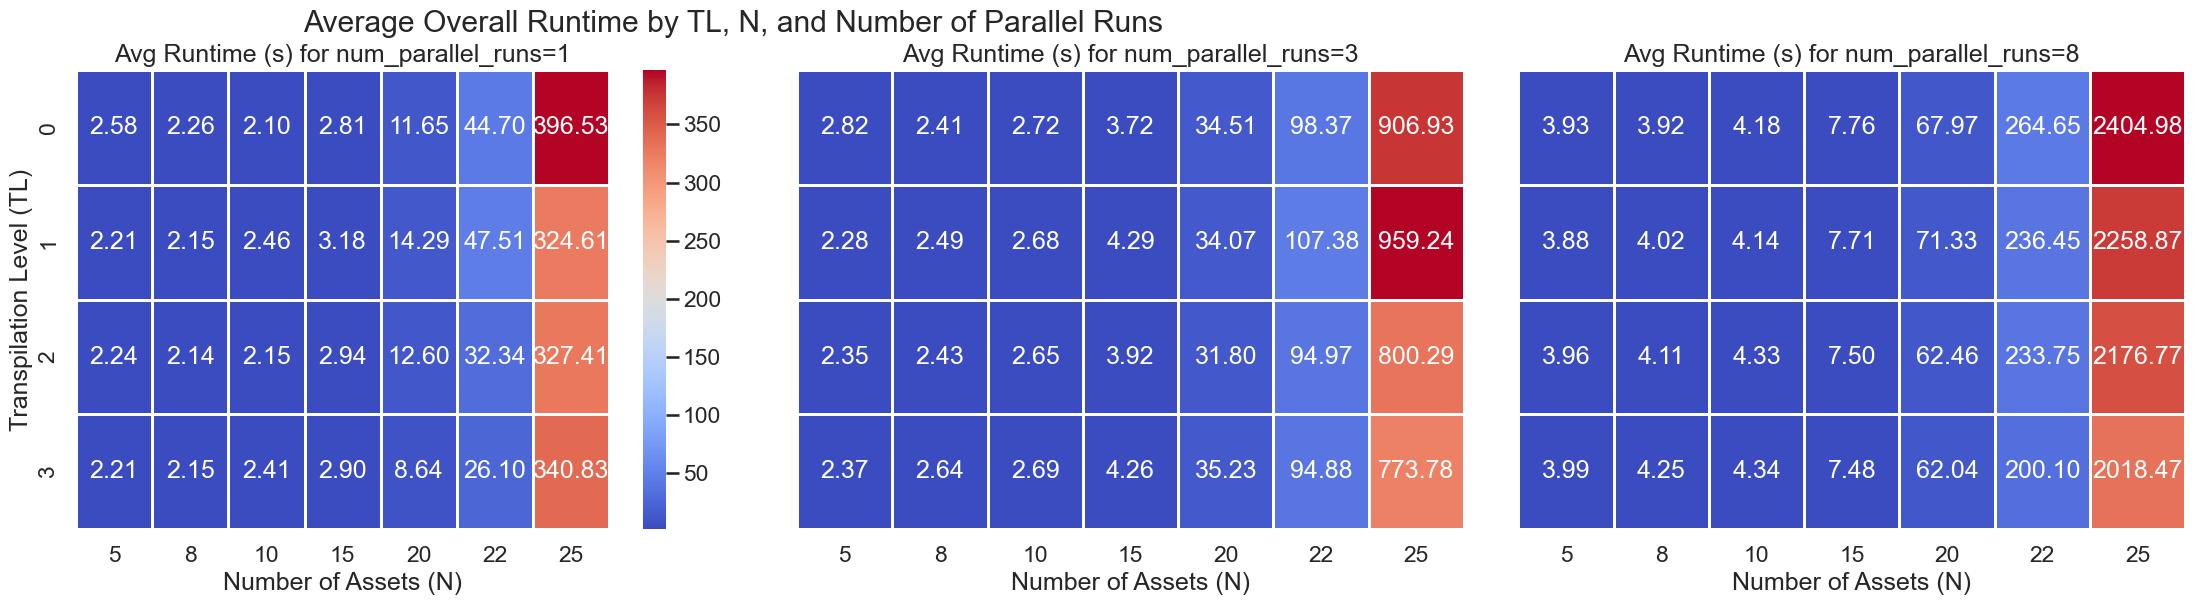


Attempting to plot Faceted Heatmaps for Average Approximation Ratio...
No valid 'approximation_ratio' data found after cleaning for faceted plot. Skipping.


In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the new CSV file into a DataFrame
try:
    results_df = pd.read_csv('qaoa_benchmarking_results_New.csv')
    print("Successfully loaded 'qaoa_benchmarking_results_New.csv'.")
    print("\nDataFrame head:")
    print(results_df.head())
    print("\nDataFrame columns:")
    print(results_df.columns)
except FileNotFoundError:
    print("Error: The file 'qaoa_benchmarking_results_New.csv' was not found.")
    exit() # Exit if the file cannot be loaded

# Ensure relevant columns are numeric, coercing errors will turn invalid parsing into NaN
results_df['approximation_ratio'] = pd.to_numeric(results_df['approximation_ratio'], errors='coerce')
results_df['overall_runtime_seconds'] = pd.to_numeric(results_df['overall_runtime_seconds'], errors='coerce')

# --- Plotting Faceted Heatmaps for Average Overall Runtime ---
print("\nAttempting to plot Faceted Heatmaps for Average Overall Runtime...")
try:
    # Drop rows where 'overall_runtime_seconds' is NaN for aggregation
    df_for_time_plot = results_df.dropna(subset=['overall_runtime_seconds', 'transpilation_level', 'N', 'num_parallel_runs'])

    if not df_for_time_plot.empty:
        # Group by the parameters and calculate the mean runtime
        pivot_df_time = df_for_time_plot.pivot_table(
            index=['transpilation_level', 'num_parallel_runs'],
            columns='N',
            values='overall_runtime_seconds',
            aggfunc='mean'
        )

        # Create a FacetGrid to plot multiple heatmaps
        # We need to reshape the pivot_df_time to a long format for FacetGrid
        # Or, manually iterate through each num_parallel_runs_value
        num_parallel_runs_values = sorted(df_for_time_plot['num_parallel_runs'].unique())
        if not num_parallel_runs_values:
            print("No 'num_parallel_runs' values found in data for runtime plot.")
        else:
            fig, axes = plt.subplots(1, len(num_parallel_runs_values), figsize=(5 * len(num_parallel_runs_values), 6), sharey=True)
            if len(num_parallel_runs_values) == 1: # Handle single subplot case
                axes = [axes]

            for i, num_runs in enumerate(num_parallel_runs_values):
                current_pivot = pivot_df_time.xs(num_runs, level='num_parallel_runs', drop_level=False)
                # Drop the num_parallel_runs level from the index for plotting
                current_pivot.index = current_pivot.index.get_level_values('transpilation_level')

                sns.heatmap(
                    current_pivot,
                    annot=True,
                    fmt=".2f",
                    cmap="coolwarm",
                    linewidths=1,
                    ax=axes[i],
                    cbar=i == 0 # Only show color bar for the first plot
                )
                axes[i].set_title(f'Avg Runtime (s) for num_parallel_runs={num_runs}')
                axes[i].set_xlabel('Number of Assets (N)')
                if i == 0:
                    axes[i].set_ylabel('Transpilation Level (TL)')
                else:
                    axes[i].set_ylabel('') # Avoid redundant y-labels

            plt.suptitle('Average Overall Runtime by TL, N, and Number of Parallel Runs', y=1.02)
            plt.tight_layout(rect=[0, 0, 1.5, 1.1]) # Adjust layout to prevent title overlap
            plt.show()
    else:
        print("No valid 'overall_runtime_seconds' data found after cleaning for faceted plot. Skipping.")

except KeyError as e:
    print(f"A column needed for plotting Overall Runtime is missing: {e}. Please check your DataFrame columns.")
except Exception as e:
    print(f"An unexpected error occurred while plotting Overall Runtime: {e}")

# --- Plotting Faceted Heatmaps for Average Approximation Ratio ---
print("\nAttempting to plot Faceted Heatmaps for Average Approximation Ratio...")
try:
    # Drop rows where 'approximation_ratio' is NaN for aggregation
    df_for_ar_plot = results_df.dropna(subset=['approximation_ratio', 'transpilation_level', 'N', 'num_parallel_runs'])

    if not df_for_ar_plot.empty:
        pivot_df_ar = df_for_ar_plot.pivot_table(
            index=['transpilation_level', 'num_parallel_runs'],
            columns='N',
            values='approximation_ratio',
            aggfunc='mean'
        )

        num_parallel_runs_values = sorted(df_for_ar_plot['num_parallel_runs'].unique())
        if not num_parallel_runs_values:
            print("No 'num_parallel_runs' values found in data for approximation ratio plot.")
        else:
            fig, axes = plt.subplots(1, len(num_parallel_runs_values), figsize=(5 * len(num_parallel_runs_values), 6), sharey=True)
            if len(num_parallel_runs_values) == 1: # Handle single subplot case
                axes = [axes]

            for i, num_runs in enumerate(num_parallel_runs_values):
                current_pivot = pivot_df_ar.xs(num_runs, level='num_parallel_runs', drop_level=False)
                current_pivot.index = current_pivot.index.get_level_values('transpilation_level')

                sns.heatmap(
                    current_pivot,
                    annot=True,
                    fmt=".3f",
                    cmap="viridis",
                    linewidths=1,
                    ax=axes[i],
                    cbar=i == 0 # Only show color bar for the first plot
                )
                axes[i].set_title(f'Avg Approx Ratio for num_parallel_runs={num_runs}')
                axes[i].set_xlabel('Number of Assets (N)')
                if i == 0:
                    axes[i].set_ylabel('Transpilation Level (TL)')
                else:
                    axes[i].set_ylabel('') # Avoid redundant y-labels

            plt.suptitle('Average Approximation Ratio by TL, N, and Number of Parallel Runs', y=1.02)
            plt.tight_layout(rect=[0, 0, 1, 0.98])
            plt.show()
    else:
        print("No valid 'approximation_ratio' data found after cleaning for faceted plot. Skipping.")

except KeyError as e:
    print(f"A column needed for plotting Approximation Ratio is missing: {e}. Please check your DataFrame columns.")
except Exception as e:
    print(f"An unexpected error occurred while plotting Approximation Ratio: {e}")

In [7]:
# so i was wondering about the initial start that we are performing here, i noticed from some analyss that i did from frawing the quantum circuit that is the result of applying the initialization and the parametrized circuiot, that the initialization is done with